# Autoencoders in Python
- general structure of an autoencoder:
    - given an input $x$, want to create a reduced dimension embedding/encoding $z = f_\theta(x)$
        - can do this by running $x$ through convolutional layers or linear layers
    - Want to reconstruct the input (increase the dimensions) to generate an output $x' = g_{\phi}(z)$ which we want to be the same as $x$, the initial output
        - i.e. we judge the model by taking the loss between $x$ and $x'$
- Why use autoencoders?
    - anomaly detection: if you train an autoencoder on one thing, and run an outlier through it, the loss will be very high
        - can easily detect an outlier in a set
    - generate new data, some ways to do that:
        - interpolate between encodings
            - get $z_1 = g(x_1), z_2 = g(x_2)$ using 2 different inputs
            - generate a new encoding $z_{\alpha} = \alpha z_1 + (1-\alpha)z_2, \alpha\epsilon [0, 1]$
                - run that through the decoder to get a new image
            - problem: picking random embeddings generates nonsense: the set of possible encodings is not smooth (discrete)
        - Variational Autoencoders
            - given data, calculate mean $\mu$ and standard deviation $\sigma$
            - randomly sample some noise $\epsilon$ from a uniform distribution
            - now can randomly generate samples $z = \mu + \sigma\epsilon$: which means $z$ comes from a normal distribution
            - now have a smooth sample space
    - pretraining (unsupervised learning methods)
        - say we have a small set of labelled data we want to classify (for example, using a CNN)
        - if we have a large dataset with no labels, we can train a full autoencoder on that data
        - then remove the decoder (i.e. we output an encoding $z = f_\theta(x)$)
        - add a linear classifier in the place of the decoder and fine tune
            - i.e. use small learning rate
        - another method: contrastive learning

### What task are we using the autoencoder for?
- let's pick pretraining

In [1]:
# Numpy
import numpy as np
import time
import matplotlib.pyplot as plt
# Import torch core functionalities
import torch
# torch neural network library
import torch.nn as nn
# Activation functions
import torch.nn.functional as F
# Optimizer to do gradient descent
import torch.optim as optim
# For stuff like data 
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

# Try using Cuda

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Step 1: Import some data
- use MNIST
    - pretend like we have no labels in the training data
    - want to make classifications on the test set

- Imagine if we had NO labels in the training set, and the "test" set in torchvision.datasets was our labelled data
- to emulate this, split the test data itself into training, validation, testing
    - the training/validation from the "test data" is our known, labelled data in this example
        - so to train the classifier, we should use this data
    - the testing data is the stuff we want to classify

For training autoencoder

In [2]:
batch_size = 50

train_data = torchvision.datasets.MNIST(root="../ann/data", train=True, download=True, transform=transforms.ToTensor())
#test_data = torchvision.datasets.MNIST(root="../ann/data", train=True, download=True, transform=transforms.ToTensor())

# Define valid_size as a percent to split train_data
valid_size = 0.20
# Want to randomly shuffle the indices so we split training data and validation data randomly
indices = list(range(len(train_data)))
# shuffle indices list
np.random.seed(1)
np.random.shuffle(indices)
# Define split as the number of samples in the validation set according to the % split defined as valid_size
split = int(valid_size * len(train_data)) 
valid_idx, train_idx = indices[:split], indices[split:] 
# Define sampler using these indices, which will be used for data loading:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

For Training Classifier

In [3]:
class_data = torchvision.datasets.MNIST(root="../ann/data", train=False, download=True, transform=transforms.ToTensor())
# len(class_data) = 10000
# Lets use:
# 8000 as our "known data" (20% validation split)
known_train = 6400
known_valid = 1600
# 2000 as the data we want to classify
known_test = 2000
# Want to randomly shuffle the indices so we split training data and validation data randomly
indices = list(range(len(class_data)))
# # shuffle indices list
np.random.seed(1)
np.random.shuffle(indices)
# # Define split as the number of samples in the validation set according to the % split defined as valid_size
# split = int(valid_size * len(train_data)) 
# valid_idx, train_idx = indices[:split], indices[split:] 
known_train, known_valid, known_test = indices[:known_train], indices[known_train:known_train + known_valid], indices[known_train + known_valid:]

print(len(known_test) + len(known_train) + len(known_valid))

# Define sampler using these indices, which will be used for data loading:
known_train_sampler = torch.utils.data.sampler.SubsetRandomSampler(known_train)
known_valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(known_valid)
known_test_sampler = torch.utils.data.sampler.SubsetRandomSampler(known_test)

known_train_loader = torch.utils.data.DataLoader(class_data, batch_size=batch_size, sampler=known_train_sampler)
known_valid_loader = torch.utils.data.DataLoader(class_data, batch_size=batch_size, sampler=known_valid_sampler)
known_test_loader = torch.utils.data.DataLoader(class_data, batch_size=batch_size, sampler=known_test_sampler)

10000


In [6]:
for (X_train, y_train) in train_loader:
    print(X_train.shape) # Batchsize x 1 x 28 x 28
    print(y_train.shape) # 1 x Batchsize
    break

torch.Size([50, 1, 28, 28])
torch.Size([50])


### Step 2: Define the model
- 2 parts: encoder, decoder
- can use nn.Sequential
- try a convolutional autoencoder:
    - need nn.Conv2d because we have 2-d input (i.e. 28x28 img)
    - 1 in-channel: no RGB or whatever (can see that from above dimension print)
    - want one out-channel (1x28x28)
- To do transfer learning: can implement a classifier in the class that we don't use till the training is done
- define some hyperparameters:

In [4]:
# standardize our kernel as 3x3
k = 3

# Encoder
in_channels = 1
conv1_in = in_channels
conv1_out = 16
conv2_in = conv1_out
conv2_out = 32
conv3_in = conv2_out
conv3_out = 64

# Decoder
tp_conv1_in = conv3_out
tp_conv1_out = conv2_out
tp_conv2_in = tp_conv1_out
tp_conv2_out = conv1_out
tp_conv3_in = tp_conv2_out
tp_conv3_out = 1

In [7]:
l1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
l2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
l3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

x = X_train[0]
print(f"Initial shape: {x.shape}")
x = l1(x)
print(f"After conv layer 1: {x.shape}")
x = l2(x)
print(f"After conv layer 2: {x.shape}")
x = l3(x)
print(f"After conv layer 3: {x.shape}")

# x = x.view(-1, 64*5*5)
# x.shape

l4 = nn.ConvTranspose2d(in_channels=64, out_channels=32,kernel_size=3)
x = l4(x)
print(f"After transpose conv layer 1: {x.shape}")
# No padding needed! 
l5 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1)
x_temp = l5(x)
print(f"After transpose conv layer 2: {x_temp.shape}")
print("need out padding + 1!")
l5_new = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
x = l5_new(x)
print(f"After padded transpose conv layer 2: {x.shape}")
l6 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1)
x_temp = l6(x)
print(f"After transpose conv layer 3: {x_temp.shape}")
print("need out padding + 1!")
l6_new = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
x = l6_new(x)
print(f"After padded transpose conv layer 3: {x.shape}")

Initial shape: torch.Size([1, 28, 28])
After conv layer 1: torch.Size([16, 14, 14])
After conv layer 2: torch.Size([32, 7, 7])
After conv layer 3: torch.Size([64, 5, 5])
After transpose conv layer 1: torch.Size([32, 7, 7])
After transpose conv layer 2: torch.Size([16, 13, 13])
need out padding + 1!
After padded transpose conv layer 2: torch.Size([16, 14, 14])
After transpose conv layer 3: torch.Size([1, 27, 27])
need out padding + 1!
After padded transpose conv layer 3: torch.Size([1, 28, 28])


In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32,kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1,output_padding=1)
        )
        # # DEFINE THE CLASSIFIER: Add this after training the autoencoder
        # self.classifier = nn.Sequential(
        #     # Input dim is output dim of the encoder (looking above: 64x5x5)
        #     nn.Linear(64*5*5, 500),
        #     nn.ReLU(),
        #     nn.Linear(500,250),
        #     nn.ReLU(),
        #     nn.Linear(250,10)
        # )
    # Forward module: just run encoder + decoder
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    # Encode: define as "embed" (since we making an embedding)
    def embed(self,x):
        return self.encoder(x)
    # Decode
    def decode(self,x):
        return self.decoder(x)
    # Classify: would be "forward" in a CNN
    def classify(self,x):
        x = self.encoder(x)
        x = x.view(-1, 64*5*5)
        x = self.classifier(x)
        return x

In [9]:
autoencoder = Autoencoder()
param_list = list(autoencoder.parameters())
len(param_list)

12

In [10]:
autoencoder

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

We can turn off the decoder by:
    - autoencoder.decoder = nn.Identity()

### Step 3: Pretraining with the autoencoder

Hyperparameters and optimizer settings
- try MSE loss, Adam optimizer

In [11]:
lr = 0.001
epochs = 50
# Batch size: defined above
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

# SEND MODEL TO CUDA
autoencoder.to(device=device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

Training loop for PRETRAINING

In [12]:
start_time = time.time()

# Variables to track things
train_losses = []
valid_losses = []
lowest_losses = [float('inf'), float('inf'), float('inf')] # each elem = ()
# store some of the predictions so we can see what they look like
train_ex = []
valid_ex = []

# Epoch loop

for i in range(epochs):

    # Batch training
    for b, (X_train, y_train) in enumerate(train_loader):

        # SEND STUFF TO CUDA
        X_train = X_train.to(device)
        # y_train = y_train.to(device) # assume we dont have this

        # start our batches at 1: so batch numbers are in the range [1, batchsize] instead of [0, batchsize-1]
        b += 1
        # make a prediction on the batch
        X_pred = autoencoder.forward(X_train) # X_train is dimension [batch_size, 3, 32, 32], making y_pred [batchsize, 10]
        # Find the loss using the loss function: BETWEEN INPUT AND OUTPUT
        loss = criterion(X_pred, X_train)
        # Computes the back-propagation for each parameter:
        loss.backward()
        # Applies the update for each parameter
        optimizer.step()
        # Cleanup step for Pytorch
        optimizer.zero_grad()

        # Print something so we can monitor the progress of the training
        if b % int(len(train_loader) / 2) == 0:
            print(f'Epoch: {i}, Batch: {b}, Training Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss
    
    # Add the final epoch accuracy and loss to train acc and train losses arrays
    train_losses.append(loss)
    # Add the final X_pred and X_train so we can plot them later
    train_ex.append((i, X_pred, X_train))

    # test on validation set: NO WEIGHT UPDATES
    with torch.no_grad():
        for b, (X_valid, y_valid) in enumerate(valid_loader):

            # SEND STUFF TO CUDA
            X_valid = X_valid.to(device)
            # y_valid = y_valid.to(device) # assume we dont have this
            X_pred = autoencoder(X_valid)

    # add final loss to valid_losses
    loss = criterion(X_pred, X_valid)
    valid_losses.append(loss)
    valid_ex.append((i, X_pred, X_valid))
    # print something to monitor the training
    print(f'Epoch: {i}, Validation Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss


end_time = time.time()
total = end_time - start_time

print(f'Training took: {total} seconds, or: {total/60} minutes!')

Epoch: 0, Batch: 480, Training Loss: 0.004914510995149612
Epoch: 0, Batch: 960, Training Loss: 0.0029783493373543024
Epoch: 0, Validation Loss: 0.002972309710457921
Epoch: 1, Batch: 480, Training Loss: 0.0020729724783450365
Epoch: 1, Batch: 960, Training Loss: 0.001571874599903822
Epoch: 1, Validation Loss: 0.0016596323112025857
Epoch: 2, Batch: 480, Training Loss: 0.001284441794268787
Epoch: 2, Batch: 960, Training Loss: 0.0009716911590658128
Epoch: 2, Validation Loss: 0.0011565854074433446
Epoch: 3, Batch: 480, Training Loss: 0.000894551572855562
Epoch: 3, Batch: 960, Training Loss: 0.0007083715172484517
Epoch: 3, Validation Loss: 0.000790964812040329
Epoch: 4, Batch: 480, Training Loss: 0.0006532590487040579
Epoch: 4, Batch: 960, Training Loss: 0.0006565309013240039
Epoch: 4, Validation Loss: 0.0006527384975925088
Epoch: 5, Batch: 480, Training Loss: 0.0005040163523517549
Epoch: 5, Batch: 960, Training Loss: 0.0004446296370588243
Epoch: 5, Validation Loss: 0.00040699695819057524
Epo

Text(0, 0.5, 'Loss')

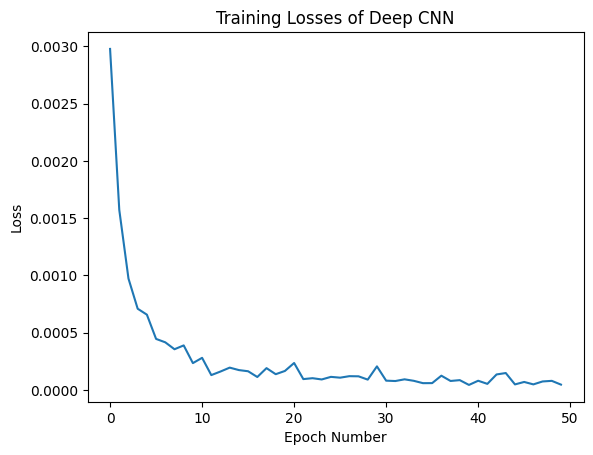

In [13]:
plt.plot(range(len(train_losses)), [x.item() for x in train_losses])
plt.title("Training Losses of Deep CNN")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

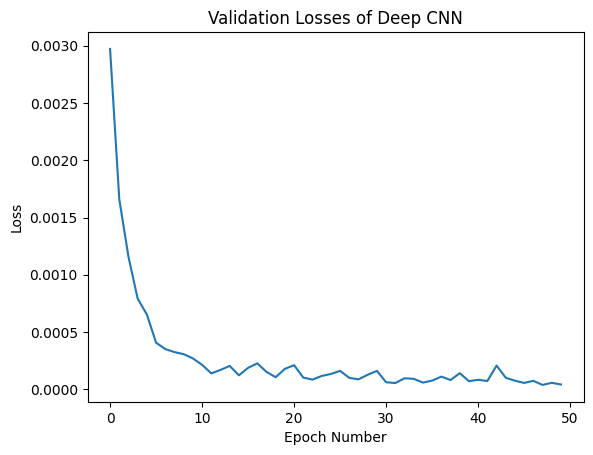

In [14]:
plt.plot(range(len(valid_losses)), [x.item() for x in valid_losses])
plt.title("Validation Losses of Deep CNN")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

# Step 4: Plug in the classifier

Edit the autoencoder so we get rid of the decoder and add a classifier

In [16]:
autoencoder.classifier = nn.Sequential(
            # Input dim is output dim of the encoder (looking above: 64x5x5)
            nn.Linear(64*5*5, 500),
            nn.ReLU(),
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,10)
        )
autoencoder.decoder = nn.Identity()

In [17]:
autoencoder

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Identity()
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=10, bias=True)
  )
)

In [18]:
# Training hyperparameters
learn_rate = 0.00001 # (1e-5)
epochs = 500 #4500

# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learn_rate)

autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Identity()
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=10, bias=True)
  )
)

test autoencoder + classifier:

In [20]:
for (X_train, y_train) in known_train_loader:
    # SEND STUFF TO CUDA
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    print(X_train.shape) # Batchsize x 1 x 28 x 28
    print(y_train.shape) # 1 x Batchsize
    break
# #pred = autoencoder.embed(X_train)
pred = autoencoder.classify(X_train)
print(pred.shape)

# my_classifier = nn.Sequential(
#             # Input dim is output dim of the encoder (looking above: 64x5x5)
#             nn.Linear(64*5*5, 500),
#             nn.ReLU(),
#             nn.Linear(500,250),
#             nn.ReLU(),
#             nn.Linear(250,10)
#         )
# my_classifier.to(device)
# pred2 = my_classifier(X_train) 

torch.Size([50, 1, 28, 28])
torch.Size([50])
torch.Size([50, 10])


In [21]:
start_time = time.time()

# Variables to track things
train_losses = []
valid_losses = []
lowest_losses = [float('inf'), float('inf'), float('inf')] # each elem = ()
# accuracy of train_corr[0] = train_corr[0]*100 / len(train_data)
train_corr = []
valid_corr = []

# Epoch loop

for i in range(epochs):
    train_corr_count = 0
    valid_corr_count = 0
    # Batch training
    for b, (X_train, y_train) in enumerate(known_train_loader):

        # SEND STUFF TO CUDA
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # start our batches at 1: so batch numbers are in the range [1, batchsize] instead of [0, batchsize-1]
        b += 1
        # make a prediction on the batch
        y_pred = autoencoder.classify(X_train) 
        # Find the loss using the loss function
        loss = criterion(y_pred, y_train)
        # Computes the back-propagation for each parameter:
        loss.backward()
        # Applies the update for each parameter
        optimizer.step()
        # Cleanup step for Pytorch
        optimizer.zero_grad()
        
        # Keep track of the accuracy of the predictions

        # predicted class gives us the index of most probability: i.e. what class the NN predicts the img is
        predicted_class = torch.max(y_pred.data, 1)[1]
        # batch_corr_count gives us the number of correct guesses in the batch
        batch_corr_count = (predicted_class == y_train).sum()
        # add that to the total number of correct guesses in the epoch
        train_corr_count += batch_corr_count

        # Print something so we can monitor the progress of the training
        if b % int(len(known_train_loader) / 2) == 0:
            print(f'Epoch: {i}, Batch: {b}, Training Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss

    # Add the final epoch accuracy and loss to train acc and train losses arrays
    train_corr.append(train_corr_count)
    train_losses.append(loss)

    # test on validation set: NO WEIGHT UPDATES
    with torch.no_grad():
        for b, (X_valid, y_valid) in enumerate(known_valid_loader):

            # SEND STUFF TO CUDA
            X_valid = X_valid.to(device)
            y_valid = y_valid.to(device)
            
            y_pred = autoencoder.classify(X_valid)
            predicted_class = torch.max(y_pred.data, 1)[1]
            batch_corr_count = (predicted_class == y_valid).sum()
            valid_corr_count += batch_corr_count
    # add final loss to valid_losses
    loss = criterion(y_pred, y_valid)
    valid_losses.append(loss)


    # print something to monitor the training
    print(f'Epoch: {i}, Validation Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss


end_time = time.time()
total = end_time - start_time

print(f'Training took: {total} seconds, or: {total/60} minutes!')

Epoch: 0, Validation Loss: 2.1504149436950684
Epoch: 1, Validation Loss: 1.810999870300293
Epoch: 2, Validation Loss: 1.352768063545227
Epoch: 3, Validation Loss: 1.018617868423462
Epoch: 4, Validation Loss: 0.7311177253723145
Epoch: 5, Validation Loss: 0.6839036345481873
Epoch: 6, Validation Loss: 0.5071069598197937
Epoch: 7, Validation Loss: 0.542371928691864
Epoch: 8, Validation Loss: 0.4837145507335663
Epoch: 9, Validation Loss: 0.4158879816532135
Epoch: 10, Validation Loss: 0.284795880317688
Epoch: 11, Validation Loss: 0.4540773630142212
Epoch: 12, Validation Loss: 0.5311197638511658
Epoch: 13, Validation Loss: 0.16398030519485474
Epoch: 14, Validation Loss: 0.39136600494384766
Epoch: 15, Validation Loss: 0.14864493906497955
Epoch: 16, Validation Loss: 0.2822953462600708
Epoch: 17, Validation Loss: 0.31699639558792114
Epoch: 18, Validation Loss: 0.24066494405269623
Epoch: 19, Validation Loss: 0.27472949028015137
Epoch: 20, Validation Loss: 0.36038124561309814
Epoch: 21, Validation

### Step 5: Evaluate Performance

Text(0, 0.5, 'Loss')

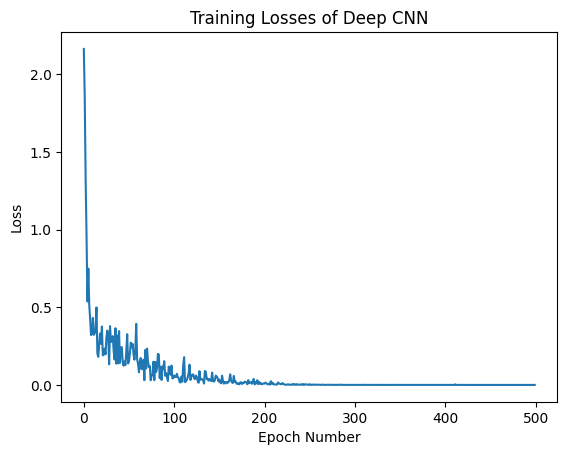

In [22]:
plt.plot(range(len(train_losses)), [x.item() for x in train_losses])
plt.title("Training Losses of Deep CNN")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

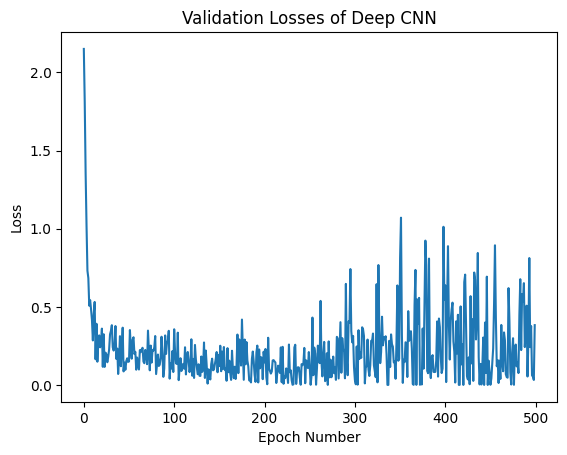

In [23]:
plt.plot(range(len(valid_losses)), [x.item() for x in valid_losses])
plt.title("Validation Losses of Deep CNN")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

In [25]:
test_losses = []
test_corr_count = 0
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(known_test_loader):
        # SEND STUFF TO CUDA
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # start our batches at 1: so batch numbers are in the range [1, batchsize] instead of [0, batchsize-1]
        b += 1
        # make a prediction on the batch
        y_pred = autoencoder.classify(X_train) 
        # Find the loss using the loss function
        loss = criterion(y_pred, y_train)

        # predicted class gives us the index of most probability: i.e. what class the NN predicts the img is
        predicted_class = torch.max(y_pred.data, 1)[1]
        # batch_corr_count gives us the number of correct guesses in the batch
        batch_corr_count = (predicted_class == y_train).sum()
        # add that to the total number of correct guesses in the epoch
        test_corr_count += batch_corr_count

        test_losses.append(loss)

Text(0, 0.5, 'Loss')

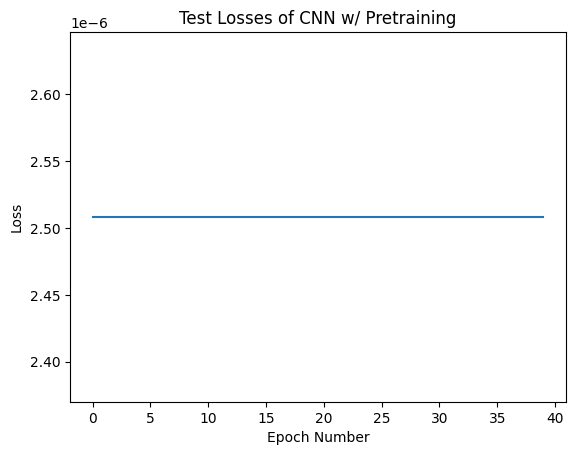

In [26]:
plt.plot(range(len(test_losses)), [x.item() for x in test_losses])
plt.title("Test Losses of CNN w/ Pretraining")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

Final Results

In [28]:
print(f"Final loss on the test set: {test_losses[-1]}")
print(f"Final Accuracy: {test_corr_count*100/len(known_test)}")
print(test_corr_count)

Final loss on the test set: 2.5081253625103272e-06
Final Accuracy: 100.00000762939453
tensor(2000, device='cuda:0')


Potential Improvements: 
- doing the three best model saving done in cnn.ipynb

# Conclusions
- this method is applicable when:
    - we have lots of unlabelled training data,. and need to classify a small amount of training data